In [24]:
#Import Data Libraries
import os
import pandas as pd
import numpy as np

#Import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Coordinate Working Libraries
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from scipy.spatial import cKDTree

In [25]:
# Impport HSC v6 and Shear/Shape Data to cross match 
hscv6 = pd.read_csv('/data/HSC/HSC_v6/HSC_v6.csv')
shapeData = pd.read_csv('/data/HSC/shear_catalog/hsc_shear_with_cuts.csv')

In [26]:
'''
    Positionally cross-match galaxies in HSC v6 and Shear/Shape data.
    Return a DataFrame of the cross-matched galaxies with all their columns
    
    csv: DataFram
        A cleaned dataframe of shape data. Assuming HSC v6 has original columns and dataframe 
        being compared has columns  'ira' and 'idec' for position
    arcsec_error: float
        The upper limit of separation we are using to define a cross-match
    Note: duplicates are possible
'''

def cross_match(csv, arcsec_error):
    #Create an empty DataFrame
    matched_df = pd.DataFrame()
    
    # Read CSV files into pandas DataFrames
    df1 = hscv6
    df2 = csv
    # Convert RA and DEC columns to SkyCoord objects
    coords1 = SkyCoord(ra=df1['ra'].values * u.degree, dec=df1['dec'].values * u.degree, frame='icrs')
    coords2 = SkyCoord(ra=df2['ira'].values * u.degree, dec=df2['idec'].values * u.degree, frame='icrs')
    
    # Perform cross-match
    # idx1: HSC v6 index
    # idx2: shape data index
    # angle: angle of separation (in degrees), not necessary
    idx2, idx1, angle, _ = coords1.search_around_sky(coords2, arcsec_error * u.arcsec) #idx1 corresponds to index in CSV2 and ixdx2 corresponds to index in CSV1
    
    #Populate empty DataFrame with columns from HSC v6 corresponding to indeces
    for columns in df1.columns.tolist():
        matched_df[columns] = df1[columns].iloc[idx1].values
        
    #Populate empty DataFrame with columns from shape data corresponding to indeces
    for columns in df2.columns.tolist():
        matched_df['shear_'+columns] = df2[columns].iloc[idx2].values

    return matched_df

In [27]:
'''
    Determine the indices that correspond to the primary galaxy and the duplicate galaxy
    at a separation limit. 
    Returns an array of tuples with primary galaxy index and duplicate galaxy index. Keeps
    the first galaxy seen
    
    data: DataFrame
        Takes a unclean cross matched dataframe. Assumes positions are defined by columns
        shear_ira and shear_idec
        
    limit: float
        A separation limit to determine what range of galaxies are to be considered 
        duplicates
    Note: inspiration for the method was taken from AstroPy search_around_sky
'''

def find_positional_duplicates(data,limit=0.8):
    coords = SkyCoord(ra=data['shear_ira'].values * u.degree, dec=data['shear_idec'].values * u.degree, frame='icrs')
    
    # Calculate the distances and indices of nearby points using ckdtree.query
    kdtree = cKDTree(coords.cartesian.xyz.T)

    # Calculate the separation in cartesian
    r= (2 * np.sin(Angle(limit * u.arcsec.to(u.deg), unit=u.deg) / 2.0)).value
    
    # The second argument of `query` is the maximum distance (0.8 arcsec converted to degrees)
    # The first return value is an array of distances, and the second return value is an array of indices
    dist, idxs = kdtree.query(coords.cartesian.xyz.T, k=1000, distance_upper_bound=r)
    
    #Find duplicates
    duplicates = []
    for i in range(len(idxs)):
        # Check if the second closest point exists within the distance threshold
        nearby_points = idxs[i][dist[i] < float('inf')]
        for j in nearby_points:
            if i < j:  # Avoid adding the point as a neighbor to itself
                duplicates.append((i, j))
    return duplicates

In [28]:
'''
    Determine if child galaxy is actually a duplicate or just within the separation limit
    Returns a 1 if a duplicate and 0 otherwise. 
    
    parent: DataFrame 
        The row of the parent as determined by find_positional_duplicates assumes 
        specz_redshift column is set for HSC v6 photoz data
    child: DataFrame
        Similarly defined as parent but for child
    zerror: float
        The amount of flexibility we are allowing in determining duplicates
'''

def same_redshift(parent, child, zerror=0.05):
    max_redshift = parent['specz_redshift'] * (1+zerror)
    min_redshift = parent['specz_redshift'] * (1-zerror)
    if min_redshift <= child['specz_redshift'] <= max_redshift:
        return 1
    else:
        return 0

In [29]:
# Cross Match shape data and HSC v6

arcsec_error = 1.0  # 1 arcsecond error

crossMatchedCat = cross_match(shapeData, arcsec_error)

len(crossMatchedCat)

68290

In [30]:
# Create an array of separation cut off limits to try, use a wide range
binCutLimits = [2, 1.6, 1.2, 1, 0.8, 0.6, 0.4]

# Create an empty 1D array that keeps track off ratios for each cut off limit
ratio = []

#Perform an analysis of what if galaxies were removed and what the ratio of removed galaxies with same redshift and total
#galaxies removed would be
for lim in binCutLimits:
    #Get the pair of indices using find_positional_duplicates
    posDupsList = find_positional_duplicates(crossMatchedCat, lim)

    #Keep track of total galaxies removed and how many have the same redshift
    numRemoved = len(posDupsList)
    num_samez = 0

    #Perform a check if they are duplicates
    for pairs in posDupsList:
        num_samez += same_redshift(crossMatchedCat.iloc[pairs[0]], crossMatchedCat.iloc[pairs[1]])
    
    #Add the ratio to a 1D array to plot later
    ratio.append(num_samez/numRemoved)

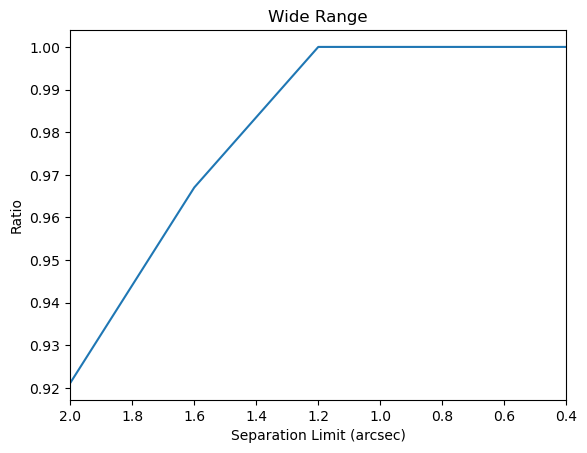

In [31]:
plt.plot(binCutLimits, ratio)
plt.xlim(max(binCutLimits), min(binCutLimits))
plt.xlabel('Separation Limit (arcsec)')
plt.ylabel('Ratio')
plt.title('Wide Range')
plt.show()

In [32]:
#Repeat the steps above but a narrower range of 1.2 to 1.4 for 100 values

binCutLimitsHone = np.linspace(1.2, 1.4, 100)
ratio = []

for lim in binCutLimitsHone:
    posDupsList = find_positional_duplicates(crossMatchedCat, lim)

    numRemoved = len(posDupsList)
    num_samez = 0

    for pairs in posDupsList:
        num_samez += same_redshift(crossMatchedCat.iloc[pairs[0]], crossMatchedCat.iloc[pairs[1]])
    
    ratio.append(num_samez/numRemoved)

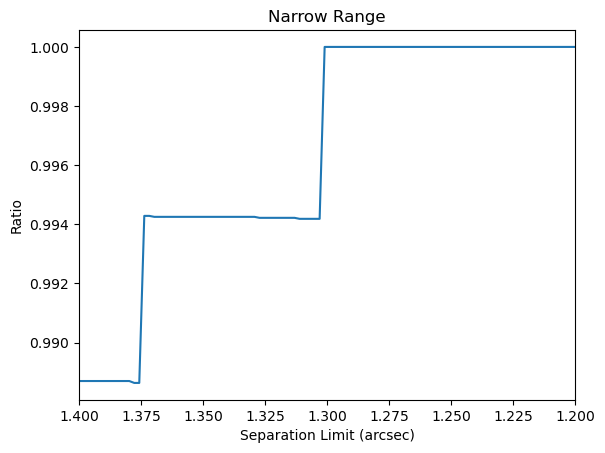

In [33]:
plt.plot(binCutLimitsHone, ratio)
plt.xlim(max(binCutLimitsHone), min(binCutLimitsHone))
plt.xlabel('Separation Limit (arcsec)')
plt.ylabel('Ratio')
plt.title('Narrow Range')
plt.show()

In [34]:
dropIdx = []

posDupsList = find_positional_duplicates(crossMatchedCat, 1.3)
for pairs  in posDupsList:
    dropIdx.append(pairs[1])

In [35]:
crossMatchedCut = crossMatchedCat.drop(dropIdx)
print(len(crossMatchedCut))

68120


In [43]:
#Check we got all duplicates
binCutLimits = np.linspace(1.29, 1.31, 100)

ratio = []
for lim in binCutLimits:
    ensureNoDups = find_positional_duplicates(crossMatchedCut, lim)

    numRemoved = len(ensureNoDups)
    num_samez = 0

    for pairs in ensureNoDups:
        num_samez += same_redshift(crossMatchedCut.iloc[pairs[0]], crossMatchedCut.iloc[pairs[1]])

    if numRemoved != 0:
        ratio.append(num_samez)
    else:
        ratio.append(-0.001)

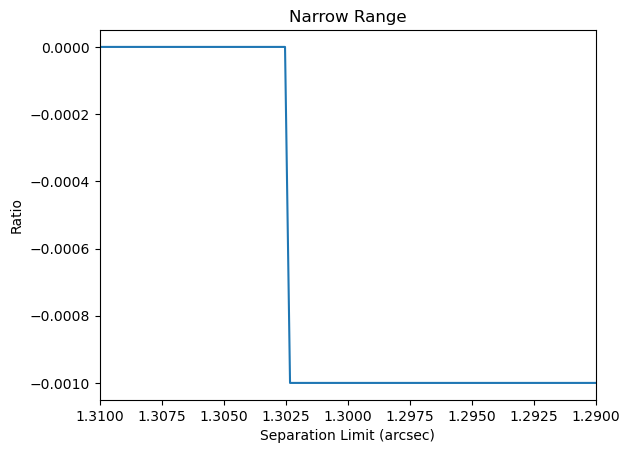

In [44]:
plt.plot(binCutLimits, ratio)
plt.xlim(max(binCutLimits), min(binCutLimits))
plt.xlabel('Separation Limit (arcsec)')
plt.ylabel('Ratio')
plt.title('Narrow Range')
plt.show()

In [45]:
crossMatchedCut.to_csv('/data/HSC/shear_catalog/hsc_v6_with_shape_and_cuts.csv', index=False)